In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

from tensorflow.keras.applications import ResNet50V2


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.16.1


In [2]:
import os

base_dir = '/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1'
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Val'))

Contents of base directory:
['Val', 'Test', 'Train']

Contents of train directory:
['Monkeypox', 'Others']

Contents of validation directory:
['Monkeypox', 'Others']


In [3]:
import os
base_dir = '/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images'
base_val = "/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1"
train_dir = os.path.join(base_dir, 'Augmented Images')
validation_dir = os.path.join(base_val, 'Val')
#train_dir = (os.listdir("/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"))
#validation_dir =  (os.listdir("/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val"))
# Directory with training cat/dog pictures
train_monkeypox_dir = os.path.join(train_dir,"Monkeypox_augmented")
train_non_monkeypox_dir = os.path.join(train_dir,"Others_augmented")


# Directory with validation cat/dog pictures
validation_monkeypox_dir = os.path.join(validation_dir,"Monkeypox")
validation_non_monkeypox_dir = os.path.join(validation_dir,"Others")

In [4]:
print('total training monkeypox images :', len(os.listdir(train_monkeypox_dir)))
print('total training non_onkeypox images :', len(os.listdir(train_non_monkeypox_dir)))

print('total validation monkeypox images :', len(os.listdir(validation_monkeypox_dir)))
print('total validation non_monkeypox images :', len(os.listdir(validation_non_monkeypox_dir)))

total training monkeypox images : 1428
total training non_onkeypox images : 1764
total validation monkeypox images : 168
total validation non_monkeypox images : 252


In [5]:
# All images will be rescaled by 1./255.
train_datagen = IDG(rescale = 1.0/255.,)
                    # rotation_range = 40,
                    # width_shift_range = 0.2,
                    # height_shift_range = 0.2,
                    # shear_range = 0.2,
                    # zoom_range = [.99, 1.01],
                    # brightness_range = [0.8, 1.2],
                    # data_format = "channels_last",
                    # fill_mode = "constant",
                    # horizontal_flip = True )

validation_datagen  = IDG( rescale = 1.0/255.,
                    validation_split=0.2)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 3350,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))
# --------------------
# Flow validation images in batches of 20 using validation_datagen generator
# --------------------
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               batch_size = 612,
                                                               class_mode  = 'categorical',
                                                               target_size = (224, 224))

test_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 122,
                                                         subset='validation',
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))


Found 3192 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [6]:
train_data, train_labels = next(train_generator)
val_data, val_labels = next(validation_generator)
test_data, test_labels = next(test_generator)

In [7]:
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)

(3192, 224, 224, 3) (3192, 2)
(420, 224, 224, 3) (420, 2)
(83, 224, 224, 3) (83, 2)


In [8]:
# Model Structure :
from keras.applications.densenet import DenseNet201
# Set the weights file you downloaded into a variable
local_weights_file = '/kaggle/input/pre/keras/default/1/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = DenseNet201(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
pre_trained_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [10]:
# Choose `conv4_block1_preact_bn` as the last layer of your base model
last_layer = pre_trained_model.get_layer('conv5_block16_0_bn')
print('last layer output shape: ', last_layer.output.shape) # Access shape through the output attribute
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 1376)


In [11]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (2, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# Changed the file extension from .h5 to .keras to align with Keras requirement
cb = [EarlyStopping(patience=10,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet50V2-01.keras",save_best_only=True)]

# Print the model summary. See your dense network connected at the end.
# model.summary()

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [13]:
history = model.fit(
      train_data,
      train_labels,
      epochs=50,
      validation_data=(val_data, val_labels),
      callbacks = cb)

Epoch 1/50


I0000 00:00:1729170033.512191      85 service.cc:145] XLA service 0x7825240026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729170033.512281      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6016 - loss: 0.7802    

I0000 00:00:1729170052.758959      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 527ms/step - accuracy: 0.7720 - loss: 0.5297 - val_accuracy: 0.9619 - val_loss: 0.1350
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9594 - loss: 0.1288 - val_accuracy: 0.9643 - val_loss: 0.1166
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9879 - loss: 0.0537 - val_accuracy: 0.9762 - val_loss: 0.0635
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9883 - loss: 0.0386 - val_accuracy: 0.9762 - val_loss: 0.0723
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.9690 - val_loss: 0.0778
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9940 - loss: 0.0222 - val_accuracy: 0.9786 - val_loss: 0.0617
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9991 - loss: 0.0058 - val_accuracy: 0.9786 - val_loss: 0.0717
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accur

In [14]:
#Evaluating the model on the data

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.9624 - loss: 0.1804
Testing Accuracy: 96.39%


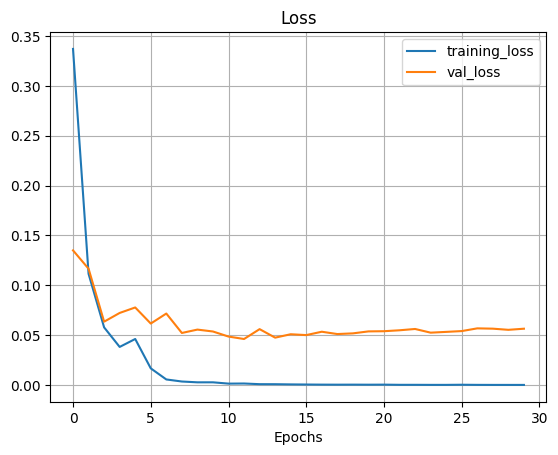

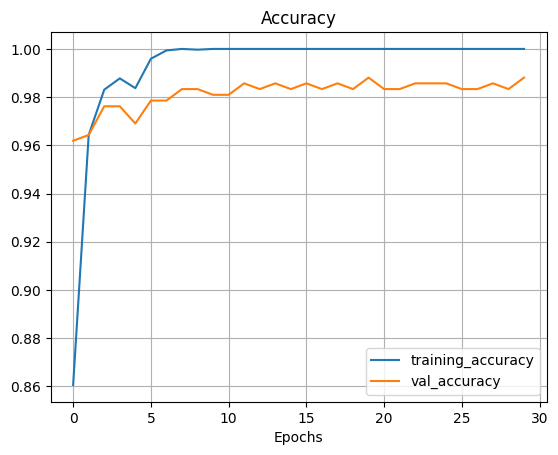

In [15]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

In [16]:
CLASSES = [ 'Monkeypox_augmented',
            'Others_augmented']

pred_labels = model.predict(test_data)
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step
                     precision    recall  f1-score   support

Monkeypox_augmented       0.94      0.97      0.96        33
   Others_augmented       0.98      0.96      0.97        50

          micro avg       0.96      0.96      0.96        83
          macro avg       0.96      0.96      0.96        83
       weighted avg       0.96      0.96      0.96        83
        samples avg       0.96      0.96      0.96        83



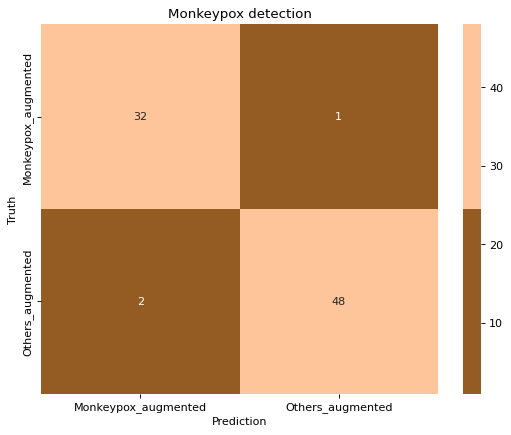

In [17]:


# Assuming pred_labels and test_labels are defined
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

# Create a custom colormap using the specified colors
cmap = sns.color_palette(["#945c23", "#fec59b"], as_cmap=True)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# Plot the heatmap with the custom colormap
ax = sns.heatmap(conf_arr, cmap=cmap, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Monkeypox detection')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


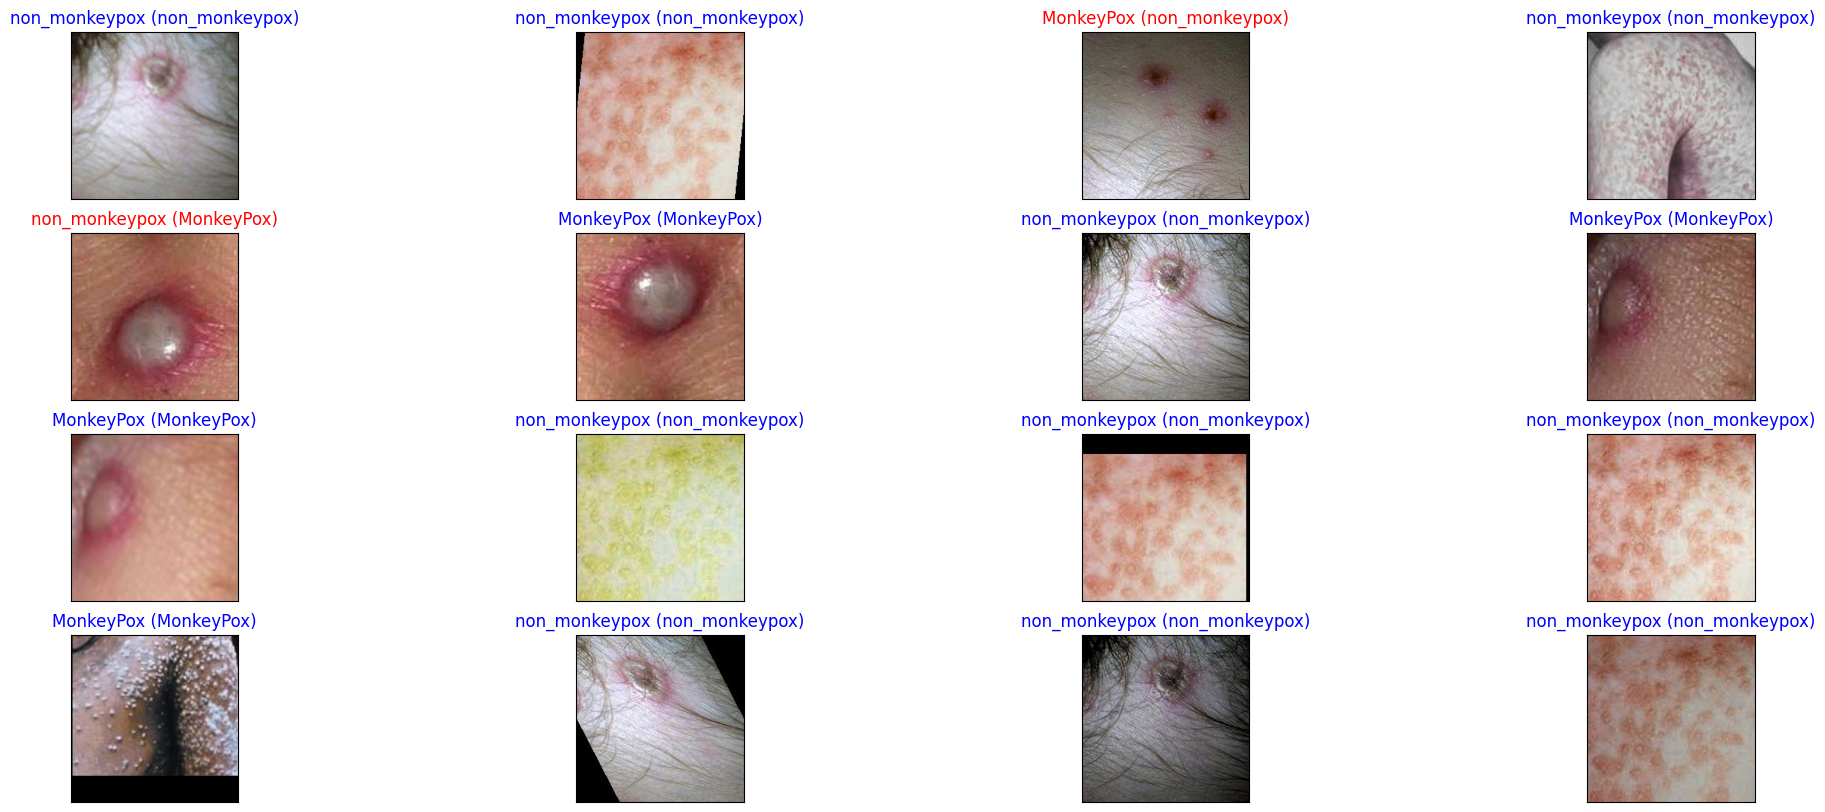

In [18]:
y_hat = model.predict(test_data)

# define text labels
m_labels = ['MonkeyPox','non_monkeypox']
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(25, 10))
for i, idx in enumerate(np.random.choice(test_data.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))